In [1]:
import numpy as np
import pandas as pd
import os
import mat73
from sklearn import svm
from sklearn import metrics
import scipy.io
from scipy import stats
import matplotlib.pyplot as plt
from scipy import stats, linalg
import warnings
import joblib

from sklearn.exceptions import ConvergenceWarning
def conv_r2z(r):
    with np.errstate(invalid='ignore', divide='ignore'):
        return 0.5 * (np.log(1 + r) - np.log(1 - r))
def conv_z2r(z):
    with np.errstate(invalid='ignore', divide='ignore'):
        return (np.exp(2 * z) - 1) / (np.exp(2 * z) + 1)

# load the arousal SVR

In [2]:
# Load the model (optional if you just saved it)
clf = joblib.load('./svr_model.pkl')
print('Model loaded successfully!')

Model loaded successfully!


In [3]:
# load the arousal network
arousal_network = scipy.io.loadmat('./arousal_network.mat')['arousal_network']

# load the feature ids
nR = 122 # the Yeo 114 atlas for cortical regions + Brainnectome atlas for subcortical
feat_id = []
ii = -1
for i in range(nR-1):
    for j in range(i+1,nR):
        ii = ii + 1
        if arousal_network[i,j] != 0: # this includes both positive and negative features
            feat_id.append(ii)
feat_id = np.array(feat_id)
print('Arousal network loaded. It has',len(feat_id),'FC features')

Arousal network loaded. It has 237 FC features


# load your own testing data -- e.g., Merlin

In [4]:
# load brain -- e.g., Merlin https://openneuro.org/datasets/ds001110/versions/00003
# your brain data needs to be parcellated using the Yeo atlas (thus 7381 FCs)
# the format of the brain data should be nsubj*nFC*nTR

brain_merlin = mat73.loadmat('../../data/brain/' + 'merlin' + '/a_output/FC/sliding-dynFeat.mat')['dynFeat']
brain_merlin = scipy.stats.zscore(brain_merlin,2,nan_policy='omit') # zscore per feature
dynFC_test = brain_merlin[:,feat_id,16:] # remove the first 16 TRs to match the movie
print('  model learn: brain entire feature shape '+str(dynFC_test.shape))

  model learn: brain entire feature shape (18, 237, 980)


In [5]:
# load behavioral ratings to test the model (optional)
arousal_merlin = scipy.io.loadmat('../../data/beh/preprocessed/group_average/conv_slidingBeh/Merlin_arousal.mat')['sliding_beh']
arousal_merlin = np.squeeze(arousal_merlin)
print('model learn: merlin arousal shape' + str(arousal_merlin.shape))

model learn: merlin arousal shape(980,)


In [6]:
# check for any missing TRs
nanidx = []
for subj in range(dynFC_test.shape[0]):
    for ft in range(dynFC_test.shape[1]):
        if np.any(np.isnan(dynFC_test[subj,ft,:])):
            nanidx.append(ft)

nanidx = np.unique(nanidx)
print('NaN = '+str(nanidx))

if len(nanidx)>0:
    dynFC_test = np.delete(dynFC_test,nanidx,1)

print('Number of nans in selected FC: '+str(len(nanidx)))
print('DynFC_test Shape: '+str(dynFC_test.shape))

NaN = []
Number of nans in selected FC: 0
DynFC_test Shape: (18, 237, 980)


# apply the model to predict arousal in the new dataset

In [7]:
test_nsubj = 18
output_acc, output_eval = [], []
for test_sub in range(test_nsubj):
    test_feat = dynFC_test[test_sub, :, :]
    test_behavior = arousal_merlin
    
    rmtr_test = []
    for tm in range(test_feat.shape[1]):
        if np.all(np.isnan(test_feat[:, tm])):
            rmtr_test.append(tm)
    rmtr_test = np.asarray(rmtr_test)
    if len(rmtr_test) > 0:
        test_feat = np.delete(test_feat, rmtr_test, 1)
        test_behavior = np.delete(test_behavior, rmtr_test, 0)
    
    predicted = clf.predict(test_feat.T)
    output_acc.append(predicted)
    
    # evaluate
    pearsonr = scipy.stats.pearsonr(test_behavior, predicted)
    mse = metrics.mean_squared_error(test_behavior, predicted)
    rsq = metrics.r2_score(test_behavior, predicted)
    output_eval.append([pearsonr[0], mse, rsq])
    
    print(' subj ' + str(test_sub + 1) + ' / ' + str(test_nsubj) + ': pearson r=' + str(
            np.round(pearsonr[0], 3)), ', mse=' + str(np.round(mse, 3)) + ', rsq=' + str(np.round(rsq, 3)))
    
output_acc, output_eval = np.asarray(output_acc), np.asarray(output_eval)

 subj 1 / 18: pearson r=-0.023 , mse=1.128, rsq=-0.129
 subj 2 / 18: pearson r=0.295 , mse=0.934, rsq=0.065
 subj 3 / 18: pearson r=0.448 , mse=0.815, rsq=0.184
 subj 4 / 18: pearson r=0.089 , mse=1.085, rsq=-0.086
 subj 5 / 18: pearson r=0.205 , mse=1.005, rsq=-0.006
 subj 6 / 18: pearson r=0.098 , mse=1.068, rsq=-0.069
 subj 7 / 18: pearson r=-0.027 , mse=1.174, rsq=-0.175
 subj 8 / 18: pearson r=0.23 , mse=0.988, rsq=0.011
 subj 9 / 18: pearson r=0.44 , mse=0.824, rsq=0.175
 subj 10 / 18: pearson r=0.1 , mse=1.045, rsq=-0.046
 subj 11 / 18: pearson r=0.382 , mse=0.878, rsq=0.121
 subj 12 / 18: pearson r=0.128 , mse=1.065, rsq=-0.066
 subj 13 / 18: pearson r=0.302 , mse=0.92, rsq=0.079
 subj 14 / 18: pearson r=0.251 , mse=0.949, rsq=0.05
 subj 15 / 18: pearson r=0.243 , mse=0.991, rsq=0.008
 subj 16 / 18: pearson r=0.332 , mse=0.895, rsq=0.104
 subj 17 / 18: pearson r=0.491 , mse=0.778, rsq=0.221
 subj 18 / 18: pearson r=0.046 , mse=1.115, rsq=-0.116


 pearson r = 0.23
 MSE       = 0.981
 r-squared = 0.018


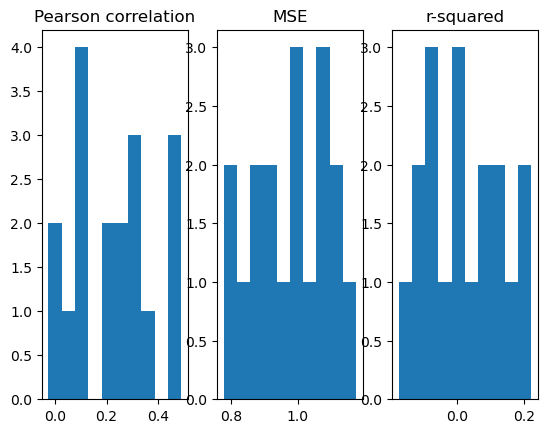

In [8]:
fig, axs = plt.subplots(1,3)
axs[0].hist(output_eval[:,0])
axs[0].set_title('Pearson correlation')
axs[1].hist(output_eval[:,1])
axs[1].set_title('MSE')
axs[2].hist(output_eval[:,2])
axs[2].set_title('r-squared')

print(' pearson r = '+str(np.round(conv_z2r(np.mean(conv_r2z(output_eval[:,0]))),3)))
print(' MSE       = '+str(np.round(np.mean(output_eval[:,1]),3)))
print(' r-squared = '+str(np.round(np.mean(output_eval[:,2]),3)))